In [1]:
import os
import numpy as np                 
import pickle                 #for storing numpy features
from tqdm.notebook import tqdm  # for visulazing how much data is processsed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg16 import  VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
    

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# defining some paths 
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working/'

# EXTRACT IMAGE FEATURES

In [3]:
#load vgg16 model
vgg_model = VGG16()
# restructuring the model since we don't need the last softmax(prediction layer)
vgg_model = Model (inputs = vgg_model.inputs, outputs = vgg_model.layers[-2].output)
#summarize
vgg_model.summary()

553467096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [4]:
# extract features from image
features = {}              # dict for storing the features of an image
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size = (224,224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    # preprocess the image for vgg
    image = preprocess_input(image)
    # extracting features 
    feature =  vgg_model.predict(image , verbose = 0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
#storing features in pickle
# this will save us re-running the above cell every time we start a new session
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
# the features computed aboove are now stored in /kaggle/input/features/features.pkl , we need to load
# them before going further
with open(os.path.join('/kaggle/input/', 'features/features.pkl'), 'rb') as f:
    features = pickle.load(f)

# **Load The Caption Data**

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# creating mapping from image to caption
mapping = {}
# preprocess the line
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # removing extension from image_ids
    image_id = image_id.split('.')[0]
    #convert caption list to string
    caption = " ".join(caption)
    # since image can have multiple captions, we will store them in a list
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

In [10]:
def clean(mapping):
    for keys, captions in mapping.items():
        for i in range (len(captions)):
            # taking one caption at a time
            caption = captions[i]
            #preprocessing step
            #converting to lower case
            caption = caption.lower()
            #delete digits, special chars, etc.
            caption = caption.replace('[^A_Za-z]', '')
            # delete additional spaces 
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [11]:
#before preprocess of text 
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
#after preprocessing 
clean(mapping)
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [13]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [14]:
len(all_captions)

40455

In [15]:
# tokenizing the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size =len(tokenizer.word_index) + 1


In [16]:
vocab_size

8485

In [17]:
# get maximum length of the caption available 
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# **Train Test Split**

In [18]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split : ]

In [19]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

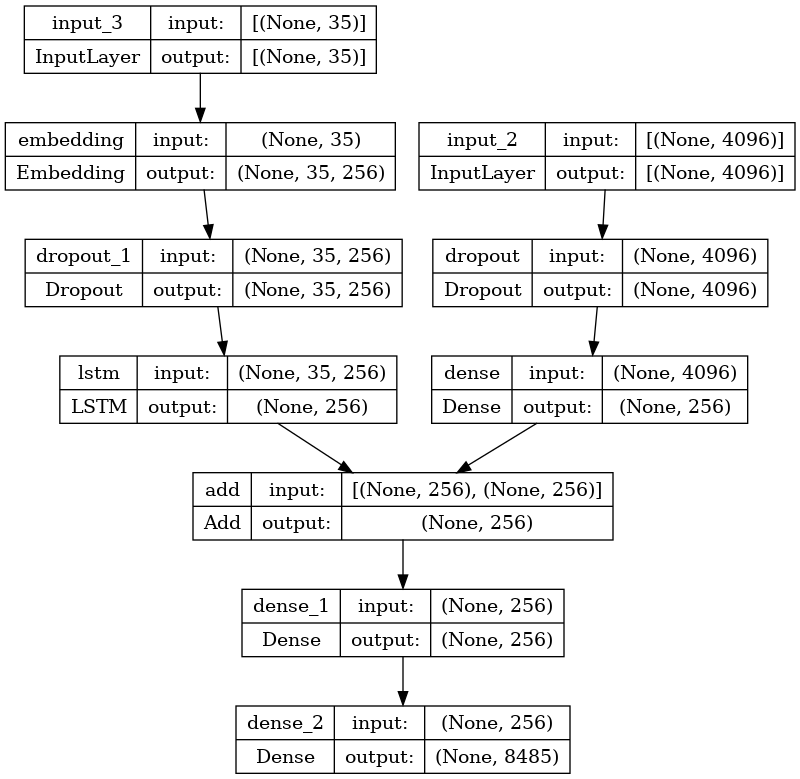

In [20]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# plot the model
plot_model(model, show_shapes=True)

In [21]:

# train the model
epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 45s 197ms/step - loss: 2.6200 - accuracy: 0.4141


# Saving model and tokenizer


In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you have functions for loading and preprocessing images and text data

def augment_images(image_ids, batch_size=32, img_height=224, img_width=224):
  """
  Loads images, applies augmentation, and yields batches for training.

  Args:
      image_ids: List of image IDs.
      batch_size: Number of images per batch.
      img_height: Target image height for resizing.
      img_width: Target image width for resizing.

  Yields:
      A tuple of (augmented_images, image_features).
  """
  train_datagen = ImageDataGenerator(
      rotation_range=40,  # Randomly rotate images up to 40 degrees
      width_shift_range=0.2,  # Shift images horizontally up to 20%
      height_shift_range=0.2,  # Shift images vertically up to 20%
      shear_range=0.2,  # Shear images up to 20 degrees
      zoom_range=0.2,  # Zoom images up to 20%
      horizontal_flip=True,  # Flip images horizontally with 50% probability
      fill_mode='nearest'  # Fill mode for padding during resizing
  )

  train_generator = train_datagen.flow_from_directory(
      directory='/kaggle/input/flickr8k/Images',  # Replace with your training images path
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical',  # Assuming categorical labels
      shuffle=True,
      seed=42  # Set a seed for reproducibility (optional)
  )

  # Load image features (modify based on your loading functions)
  image_features = load_image_features(image_ids)  # Replace with your function

  for augmented_images, _ in train_generator:
    yield augmented_images, image_features

def create_data_generator(image_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  """
  Creates a generator that yields batches of image features, sequence features, and labels.

  Args:
      image_ids: List of image IDs for the current batch.
      mapping: Dictionary mapping image IDs to sequence data.
      features: Dictionary containing image features (modify based on your loading).
      tokenizer: Text tokenizer.
      max_length: Maximum sequence length.
      vocab_size: Vocabulary size.
      batch_size: Number of samples per batch.

  Yields:
      A tuple of (image_features, sequence_features, labels).
  """
  while True:
    batch_image_ids = image_ids[:batch_size]  # Get a batch of image IDs
    image_ids = image_ids[batch_size:]  # Remove processed IDs from remaining list

    batch_image_features = [features[image_id] for image_id in batch_image_ids]
    batch_sequence_features = [mapping[image_id] for image_id in batch_image_ids]
    batch_sequence_features = tokenizer.texts_to_sequences(batch_sequence_features)
    batch_sequence_features = tf.keras.preprocessing.sequence.pad_sequences(
        batch_sequence_features, maxlen=max_length, padding='post')

    # Assuming you have a function to get labels based on image IDs
    batch_labels = get_labels(batch_image_ids)

    yield batch_image_features, batch_sequence_features, batch_labels

    if not image_ids:  # Break loop if all image IDs are processed
      break

epochs = 20
batch_size = 32

# ... (assuming you have pre-loaded train and test image IDs)

for epoch in range(epochs):
  # Create data generators for training and validation (if applicable)
  train_generator = create_data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
  # val_generator = create_data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)  # For validation

  # Train the model
  model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


227/227 [==============================] - 45s 199ms/step - loss: 2.5665 - accuracy: 0.4292


In [23]:
# save the model
model.save(WORKING_DIR+'/model.h5')

In [24]:
# save the model
model.save('/kaggle/working/model.h5')

In [25]:
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Loading the model and tokenizer from the file

In [26]:
#load model from file
# the model below is trained for around 50 epochs, this is the best I can do given the limited computation and time I have.
import tensorflow as tf
model = tf.keras.models.load_model('/kaggle/input/image-caption-generator-model-bleu051/model.h5')

In [27]:
# loading
with open('/kaggle/input/image-caption-generator-model-bleu051/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Generate Captions for the Image

In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

> **Evaluating the result**

In [30]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test[:20]):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, 35) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/20 [00:00<?, ?it/s]

BLEU-1: 0.486837
BLEU-2: 0.282156


**NOTE**
this is the score on just 20 images from test dataset. Actual BLEU-1 score on all the images from test dataset is close to 0.51 

# Visualize the Results

In [31]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq child with helmet on his head rides bike endseq
startseq little boy rides bike down hill on miniature dirt bike endseq
startseq young boy in helmet rides bike on the road endseq
startseq the little boy rides his bicycle in race endseq
startseq the young boy pedals quickly at bmx race endseq
--------------------Predicted--------------------
startseq boy in blue and white uniform riding bike in the woods endseq


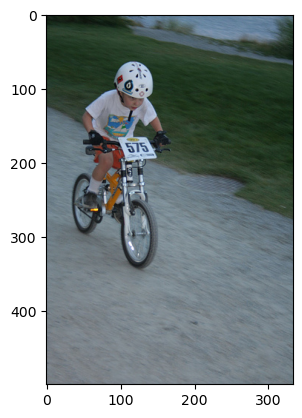

In [32]:
generate_caption("1075716537_62105738b4.jpg")

***Code to predict caption of real images ***

---------------------Actual---------------------
startseq person on snowmobile in mid jump endseq
startseq snowmobiler flies through the air endseq
startseq snowmobile rider flies through the air on his or her machine in front of tall pine trees endseq
startseq rider jumps snowmobile high in rural area endseq
startseq the man is up in the air endseq
--------------------Predicted--------------------
startseq snowmobile rider flies through the air endseq


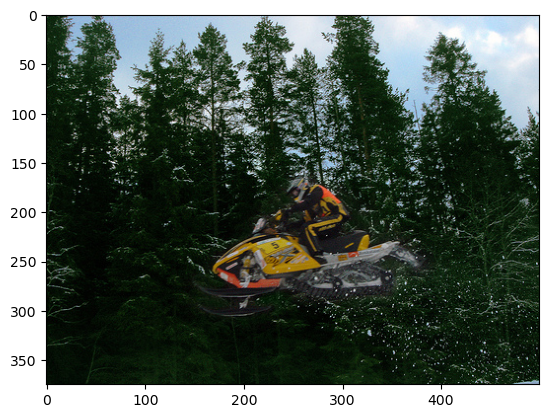

In [33]:
generate_caption("109738763_90541ef30d.jpg")

---------------------Actual---------------------
startseq man eats near tent in the snow endseq
startseq man sitting near tent in the snow and ice endseq
startseq mountaineer sits in the snow in front of yellow tent under clear blue sky endseq
startseq person wearing hooded jacket sitting on snow in front of yellow tent endseq
startseq young man in hooded jacket sitting on snow in mountain area endseq
--------------------Predicted--------------------
startseq mountaineer is sitting in the snow with tent on his head endseq


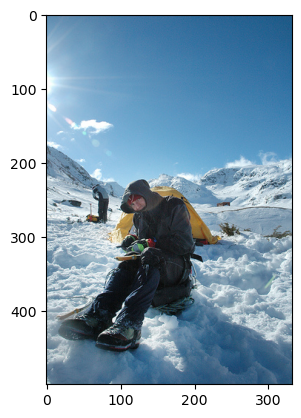

In [34]:
generate_caption("116409198_0fe0c94f3b.jpg")

In [35]:
image_path = "/kaggle/input/flickr8k/Images/101654506_8eb26cfb60.jpg" #path of your image
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, 35)

'startseq two dogs are playing in snow endseq'